In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from datetime import datetime
import multiprocessing as mp
sys.path.insert(0, '../../data/siim-pneumothorax')

import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image

fastai.__version__


'1.0.54'

In [2]:
sz = 256
bs = 8
n_acc = 64//bs #gradinet accumulation steps
nfolds = 4
SEED = 2019

data_path = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

if sz == 256:
    stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
    TRAIN = os.path.join(data_path, 'train_png_256')
    TEST = os.path.join(data_path, 'test_png_256')
    MASKS = os.path.join(data_path, 'mask_png_256')
elif sz == 128:
    stats = ([0.615,0.615,0.615],[0.291,0.291,0.291])
    TRAIN = '../input/siimacr-pneumothorax-segmentation-data-128/train'
    TEST = '../input/siimacr-pneumothorax-segmentation-data-128/test'
    MASKS = '../input/siimacr-pneumothorax-segmentation-data-128/masks'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [3]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [4]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [5]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [6]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [7]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    preds, ys = learn.get_preds(ds_type)
    preds = preds[:,1,...]
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = learn.get_preds(ds_type)
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    del preds_lr
    gc.collect()
    torch.cuda.empty_cache()
    return preds, ys

In [8]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

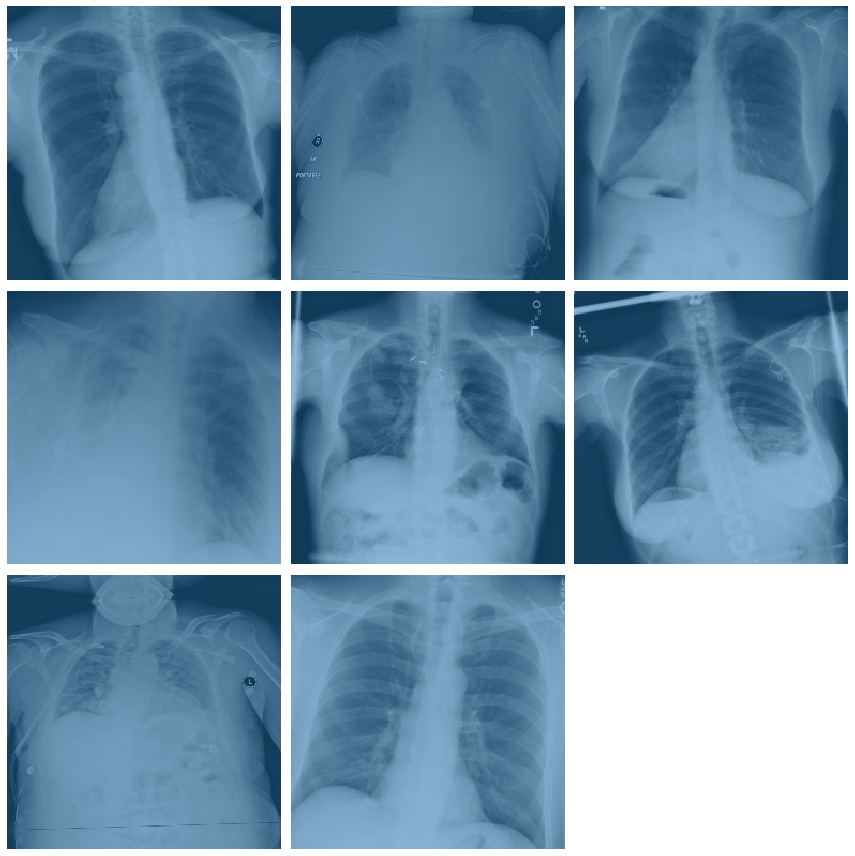

In [9]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'mask'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

## Training


In [10]:
scores, best_thrs = [],[]
now = datetime.now()

for fold in range(nfolds):
    print('fold: ', fold)
    data = get_data(fold)
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    #fit the decoder part of the model keeping the encode frozen
    lr = 1e-3
    learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('unet_{}_fold{}'.format(now.strftime('%Y%m%d-%H%M%S'), fold));
    
    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    pt, _ = pred_with_flip(learn,DatasetType.Test)
    
    if fold == 0: preds_test = pt
    else: preds_test += pt
        
    #convert predictions to byte type and save
    preds_save = (preds*255.0).byte()
    torch.save(preds_save, 'preds_fold'+str(fold)+'.pt')
    np.save('items_fold'+str(fold), data.valid_ds.items)
        
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])
     
    if fold != nfolds-1: del preds, ys, preds_save
    gc.collect()
    torch.cuda.empty_cache()
    
preds_test /= nfolds

In [11]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

scores:  [0.8167212, 0.8134234, 0.8153694, 0.80803347]
mean score:  0.81338686
thresholds:  [0.25, 0.24000000000000002, 0.3, 0.26]
best threshold:  0.2625


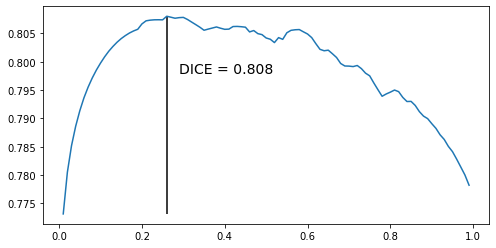

In [12]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

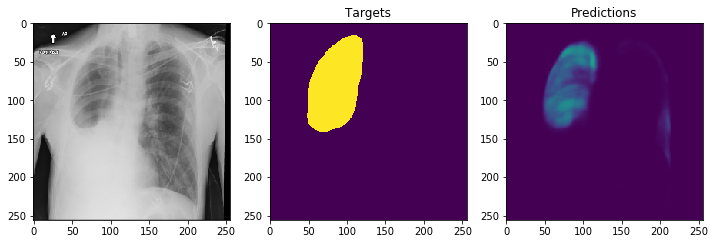

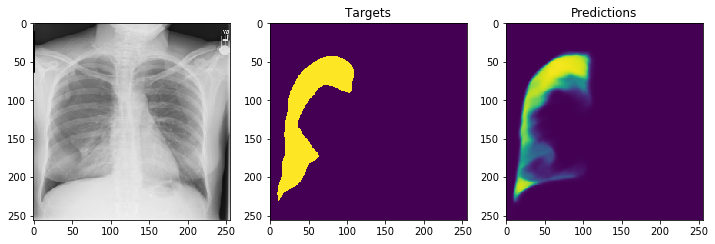

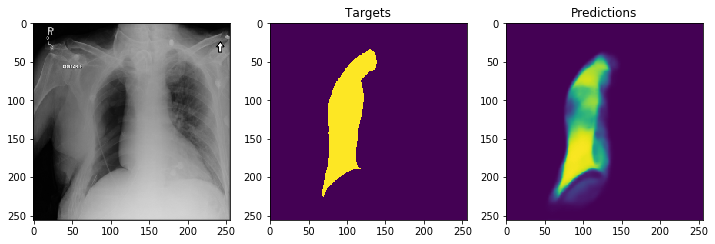

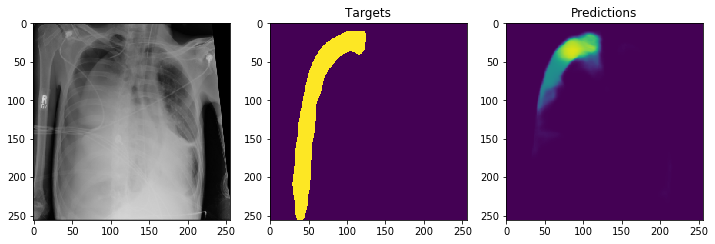

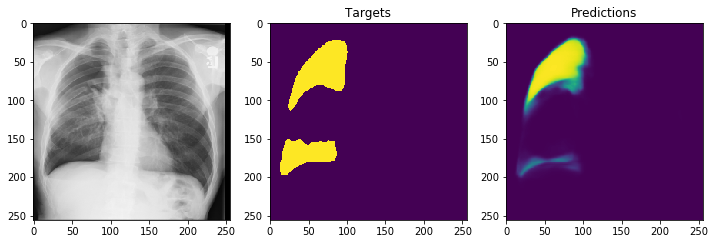

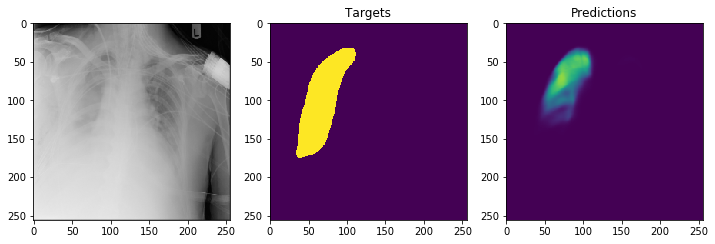

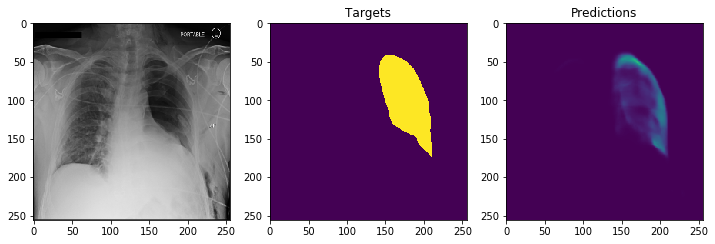

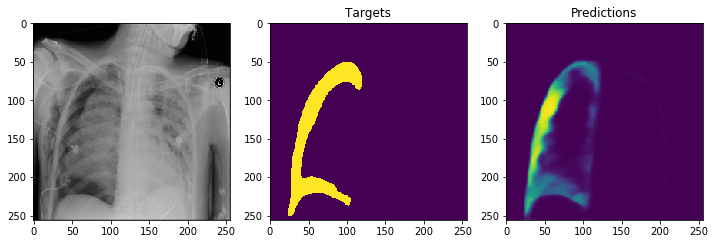

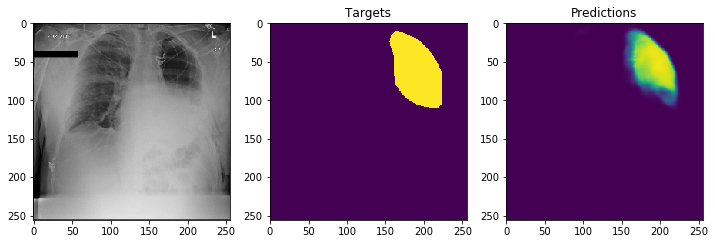

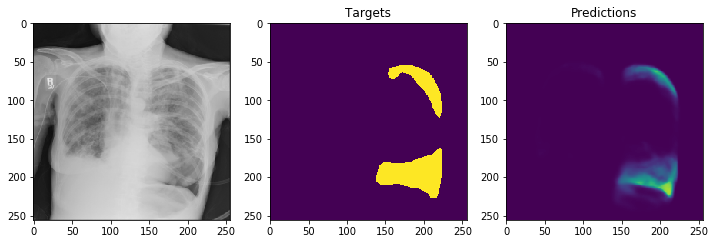

In [13]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## Alternatively, let's load and eval  


In [10]:
date_tag = '20190716-171659'

scores, best_thrs = [],[]

for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data(fold)
    
    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.load('unet_{}_fold{}'.format(date_tag, fold))
    
    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
        
    #convert predictions to byte type and save
    preds_save = (preds*255.0).byte()
    torch.save(preds_save, 'preds_fold'+str(fold)+'.pt')
    np.save('items_fold'+str(fold), data.valid_ds.items)
        
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    
    preds.cuda()
    ys.cuda()
    
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])
     
    if fold != nfolds-1: del preds, ys, preds_save
    gc.collect()
    torch.cuda.empty_cache()


In [11]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

scores:  [0.81672084, 0.8134234, 0.8153694, 0.80803347]
mean score:  0.8133868
thresholds:  [0.25, 0.24000000000000002, 0.3, 0.26]
best threshold:  0.2625


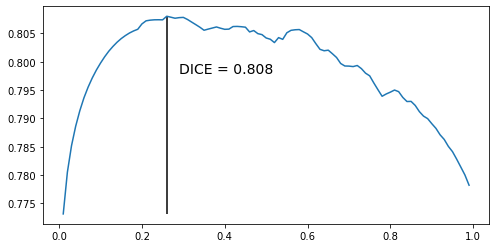

In [12]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

## submission


In [10]:
best_thr = 0.2625

In [11]:
date_tag = '20190716-171659'

for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data(fold)
    
    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.load('unet_{}_fold{}'.format(date_tag, fold))
    
    #prediction on val and test sets
    pt, _ = pred_with_flip(learn,DatasetType.Test)
    
    if fold == 0:
        ptt = pt
    else:
        ptt += pt


In [ ]:
ptt /= nfolds

In [21]:
# save ptt
torch.save(ptt, 'unet_ptt.pth')

In [13]:
# majority vote - no we don't actually use vote
pt_vote = torch.where(ptt > best_thr, torch.ones_like(ptt), torch.zeros_like(ptt))


In [14]:
# noise removal

pt_vote[pt_vote.view(pt_vote.shape[0],-1).sum(-1) < noise_th,...] = 0.0
pt_vote = pt_vote.numpy()


In [15]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)
    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rles = pool.map(mask_worker, pt_vote)


In [16]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.to_csv('unet_{}_{}folds.csv'.format(date_tag, nfolds), index=False)
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


## classifier probe

In [20]:
cls_rles = ['-1' if rle != '' else '1 2' for rle in rles]
cls_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': cls_rles})
cls_df.loc[cls_df.EncodedPixels=='', 'EncodedPixels'] = '1 2'
cls_df.to_csv('unet_{}_{}folds_cls.csv'.format(date_tag, nfolds), index=False)
cls_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,1 2
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,1 2
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,1 2
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,1 2
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,1 2
